# 3945 – Advanced Machine Learning, Spring 2022
## Home Assignment 2 – Ensemble Learning

In this assignment, you will implement Ensemble Learning methods - Gradient Boosting Regression Trees (GBRT) and AdaBoost. You will demonstrate the models and design experiments to test their performance. You will submit a single ipython notebook (.ipynb) file that includes all the code and outputs, as well as a brief report that explains your approach and findings. You are encouraged to use methods and techniques covered in class but are also welcome to use any other relevant method you find suitable for the task.

Submission Guidelines
• Submit the work in pairs. Only one submission for each pair.

• Your submission should include a single zip file containing:

• A single ipython notebook (.ipynb) file that includes all the code and outputs.

• A brief report (1-2 pages) in a pdf format that explains your approach and findings.

• The submitted file should follow the naming convention:
3945_HW2_XXX_YYY.zip
Where:
o XXX and YYY are your student numbers (IDs)
For example: 3945_HW1_123456789_987654321.zip

• Make sure to run your notebook from start to finish before submitting to ensure that it runs without errors.

• You may use external libraries. Specify all required libraries in a proper manner.

• Grading will be based on correctness, elegance of solution, and style (comments, naming conventions, etc.)

• Your report should be clear, coherent, and concise.

• All figure and plots should include captions, labels and data units. Pay attention to data visualization guidelines.

• Make sure to use correct ML methodologies and justify your selections (split the data to train/test, tune hyperparameters, report relevant performance measures).

## Imports and Set-Up

In [ ]:
import os

In [ ]:
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=955a2f2cfd6863a48fc160298a276264b3e7116661eff7eda7396848c6f859a1
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=84678fbdbcd9fb45c9586ecedb66de1fda7620249fa3d363d14ca838192350d5
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_curve, auc
from itertools import product
import umap
from umap import UMAP
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D


import tqdm
import math
import time
import seaborn as sns
import numpy as np
import itertools

### Part 0: Generate datasets

Generate at least two datasets with one binary label.

In [ ]:
# Dataset 1: 5 features and 5000 samples
X1, y1 = make_classification(n_samples=5000, n_features=5, n_informative=4, n_redundant=0, n_clusters_per_class=1, random_state=42, weights=[0.75, 0.25])
y1 = np.where(y1 == 0, 0, 1) # Convert to binary


# Dataset 2: 7 featuees and 5000 samples
X2, y2 = make_classification(n_samples=5000, n_features=7, n_informative=5, n_redundant=2, n_clusters_per_class=1, random_state=11)
y2 = np.where(y2 == 0, 0, 1) # Convert to binary

Split the data to train and test sets

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.25, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=11)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.25, random_state=42)

Visualize the data

In [ ]:
def plot_label_distribution(y1, y2):
  unique_labels1, label_counts1 = np.unique(y1, return_counts=True)
  unique_labels2, label_counts2 = np.unique(y2, return_counts=True)
  sns.set_palette("Set2")
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  sns.barplot(x=unique_labels1, y=label_counts1)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.title('Dataset 1 (Unbalanced Data) - Label Distribution')

  plt.subplot(1, 2, 2)
  sns.barplot(x=unique_labels2, y=label_counts2)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.title('Dataset 2 (Balanced Data) - Label Distribution')

  plt.tight_layout()
  plt.show()

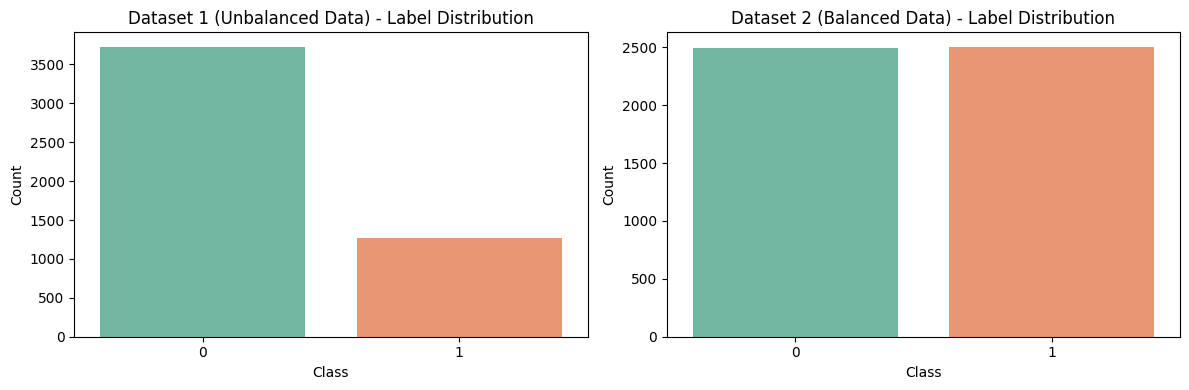

In [ ]:
plot_label_distribution(y1, y2)

In [ ]:
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1)
X2_pca = pca.fit_transform(X2)

umap_2d = umap.UMAP(n_components=2)
X1_umap = umap_2d.fit_transform(X1)
X2_umap = umap_2d.fit_transform(X2)

umap_3d = umap.UMAP(n_components=3)
X1_umap_3d = umap_3d.fit_transform(X1)
X2_umap_3d = umap_3d.fit_transform(X2)

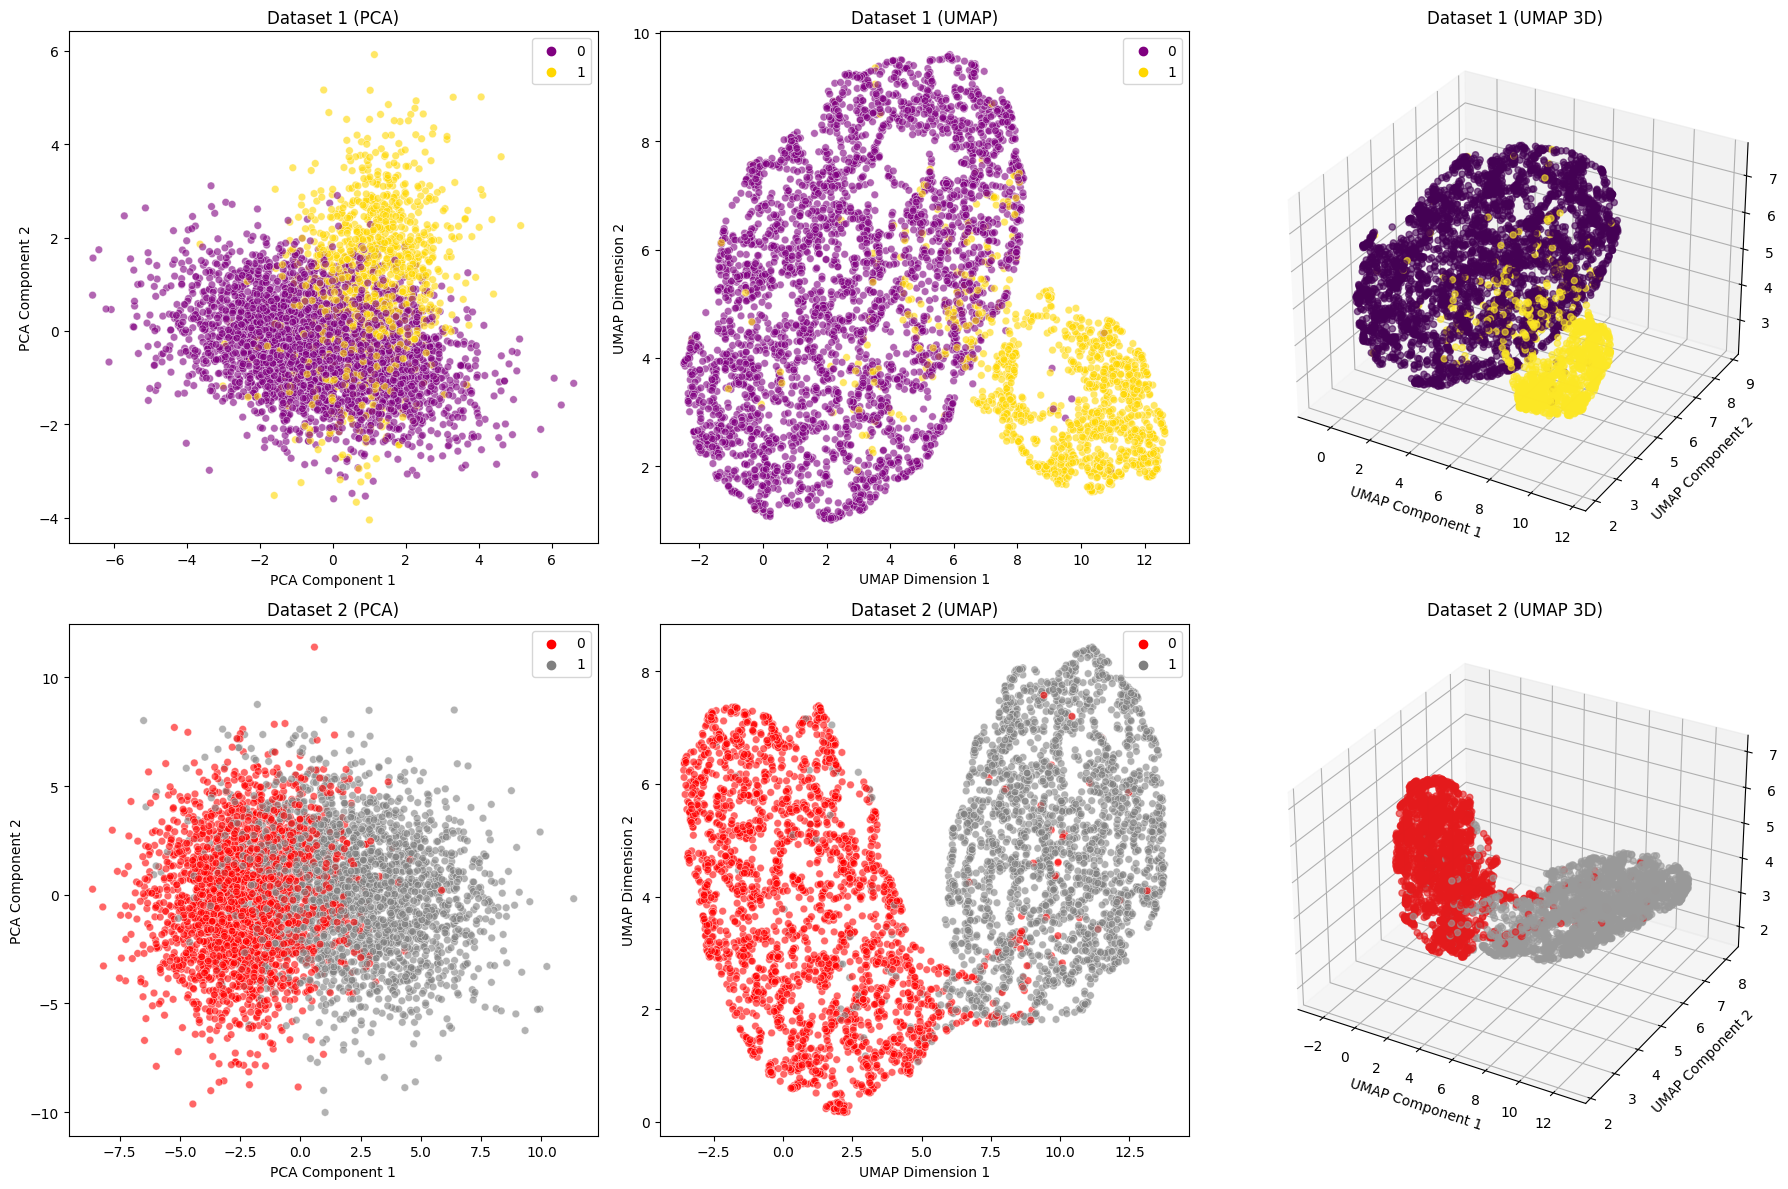

In [ ]:
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(2, 3, 1)
sns.scatterplot(x=X1_pca[:, 0], y=X1_pca[:, 1], hue=y1, palette=['purple', 'gold'], alpha=0.6, s=30, ax=ax1)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title('Dataset 1 (PCA)')

ax2 = fig.add_subplot(2, 3, 2)
sns.scatterplot(x=X1_umap[:, 0], y=X1_umap[:, 1], hue=y1, palette=['purple', 'gold'], alpha=0.6, s=30, ax=ax2)
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
ax2.set_title('Dataset 1 (UMAP)')

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(X1_umap_3d[:, 0], X1_umap_3d[:, 1], X1_umap_3d[:, 2], c=y1, alpha=0.6)
ax3.set_xlabel('UMAP Component 1')
ax3.set_ylabel('UMAP Component 2')
ax3.set_zlabel('UMAP Component 3')
ax3.set_title('Dataset 1 (UMAP 3D)')

ax4 = fig.add_subplot(2, 3, 4)
sns.scatterplot(x=X2_pca[:, 0], y=X2_pca[:, 1], hue=y2, palette=['red', 'grey'], alpha=0.6, s=30, ax=ax4)
ax4.set_xlabel('PCA Component 1')
ax4.set_ylabel('PCA Component 2')
ax4.set_title('Dataset 2 (PCA)')

ax5 = fig.add_subplot(2, 3, 5)
sns.scatterplot(x=X2_umap[:, 0], y=X2_umap[:, 1], hue=y2, palette=['red', 'grey'], alpha=0.6, s=30, ax=ax5)
ax5.set_xlabel('UMAP Dimension 1')
ax5.set_ylabel('UMAP Dimension 2')
ax5.set_title('Dataset 2 (UMAP)')

ax6 = fig.add_subplot(2, 3, 6, projection='3d')
ax6.scatter(X2_umap_3d[:, 0], X2_umap_3d[:, 1], X2_umap_3d[:, 2], c=y2, cmap='Set1', alpha=0.6)
ax6.set_xlabel('UMAP Component 1')
ax6.set_ylabel('UMAP Component 2')
ax6.set_zlabel('UMAP Component 3')
ax6.set_title('Dataset 2 (UMAP 3D)')

plt.tight_layout()
plt.show()

### Part 1: Gradient Boosting Regression Trees (GBRT)

#### Implement GBRT

In [ ]:
class GBRT:
  def __init__(self, learning_rate=0.1, n_estimators=10, max_depth=1, min_samples_leaf=1):
    self.learning_rate = learning_rate
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.mse = []
    self.residuals = []
    self.predictions = []
    self.target_train = []
    self.target_test = []
    self.train = []
    self.test = []
    self.results = []

  def _residuals(self, y_true, y_pred):
    return y_true - y_pred

  def weak_tree(self, X, y):
    """ This function fits a base tree to the passed data to return a newly trained tree

    X is the feature matrix
    y is the binary labels
    """
    tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
    return tree.fit(X, y)

  def boost(self, X_train, y_train, X_test, y_test, test = False):
    self.train = X_train
    self.target_train = y_train
    self.test = X_test
    self.target_test = y_test
    y_pred_train = np.zeros(len(self.target_train), dtype=np.float64)
    y_pred_test = np.zeros(len(self.test), dtype=np.float64)
    for _ in range(self.n_estimators):
      residuals = self._residuals(self.target_train, y_pred_train)
      self.residuals.append(residuals)
      tree = self.weak_tree(self.train, residuals)
      y_pred_train += self.learning_rate * tree.predict(self.train)
      y_pred_test += self.learning_rate * tree.predict(self.test)
      self.mse.append(self._mse(self.target_train, y_pred_train))
    self.predictions = np.where(y_pred_test > 0.5, 1, 0)

    if test: return self.predictions

  def grid_search(self, params):
    param_combinations = list(product(*params.values()))
    best_accuracy = 0.0
    best_params = {}

    for combination in param_combinations:
      param_dict = dict(zip(params.keys(), combination))
      self.learning_rate = param_dict['learning_rate']
      self.n_estimators = param_dict['n_estimators']
      self.max_depth = param_dict['max_depth']
      self.min_samples_leaf = param_dict['min_samples_leaf']

      y_pred = self.boost(self.train, self.target_train, self.test, self.target_test, test=True)
      acc = accuracy_score(self.target_test, y_pred) * 100
      result = (param_dict['learning_rate'], param_dict['n_estimators'], param_dict['max_depth'], param_dict['min_samples_leaf'], acc)
      self.results.append(result)

      param_string = ', '.join([f"{key}={val}" for key, val in param_dict.items()])
      print(f"Accuracy for {param_string}: {acc}")

      if acc > best_accuracy:
        best_accuracy = acc
        best_params = param_dict

    return best_accuracy, best_params

  def print_results(self, data=None):
    accuracy = accuracy_score(self.target_test, self.predictions) * 100
    precision = precision_score(self.target_test, self.predictions, pos_label=1) * 100
    recall = recall_score(self.target_test, self.predictions, pos_label=1) * 100
    f1 = f1_score(self.target_test, self.predictions, pos_label=1) * 100

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    values = [accuracy, precision, recall, f1]
    colors = sns.color_palette('Set2')[:len(metrics)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(x=metrics, y=values, palette=colors, ax=ax1)
    ax1.set_xlabel('Metrics', size=12)
    ax1.set_ylabel('Value', size=12)
    ax1.set_title('Evaluation Metrics', size=14)
    ax1.set_ylim(0, 100)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    cm = confusion_matrix(self.target_test, self.predictions)
    labels = list(np.unique(self.target_test))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_xlabel('Predicted', size=12)
    ax2.set_ylabel('True', size=12)
    ax2.set_title(f'Confusion Matrix', size=14)

    fig.suptitle(f'GBRT on Dataset {data} Test Data Results', fontsize=20)
    plt.tight_layout()
    plt.show()

    print(classification_report(self.target_test, self.predictions))

  def roc(self, data):
    fpr, tpr, thresholds = roc_curve(self.target_test, self.predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 10))
    sns.lineplot(x=fpr, y=tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.title(f'Receiver Operating Characteristic for Dataset {data} on Test Data', size=18)
    plt.legend(loc='lower right')
    plt.show()

  def plot_mse(self, data=None):
    sns.lineplot(x=range(1, self.n_estimators + 1), y=self.mse, marker='o')
    plt.xlabel('Iteration', size=14)
    plt.ylabel('MSE', size=14)
    plt.title(f'MSE for Each Iteration', size=18)
    plt.ylim(0, max(self.mse) + 0.5)
    plt.grid(True)

  def _mse(self, y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

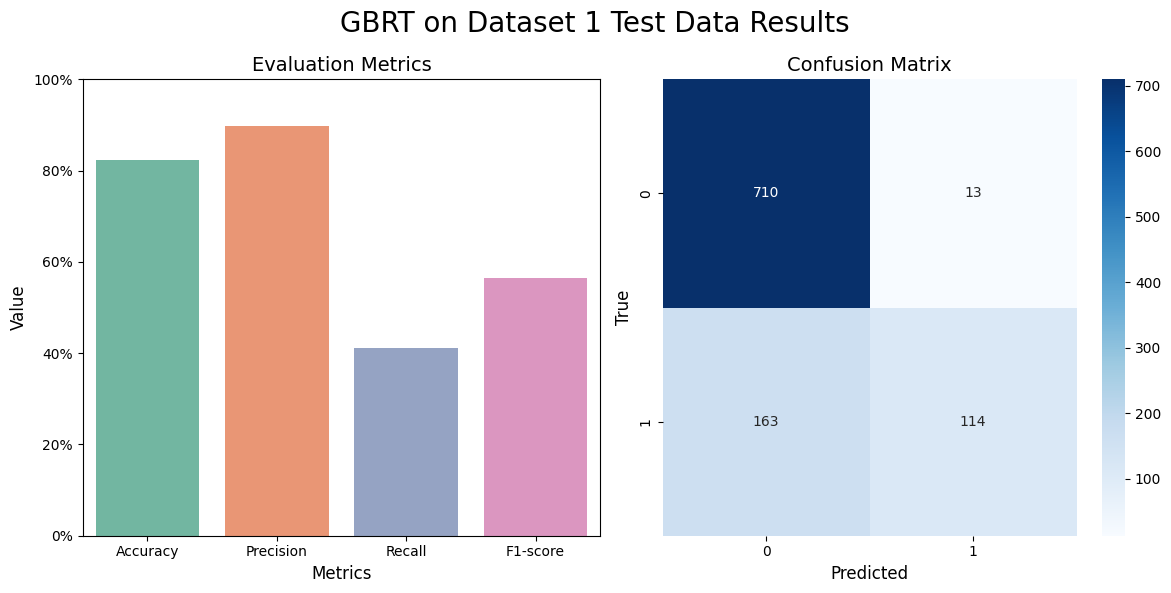

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       723
           1       0.90      0.41      0.56       277

    accuracy                           0.82      1000
   macro avg       0.86      0.70      0.73      1000
weighted avg       0.84      0.82      0.80      1000



In [ ]:
gbrt1 = GBRT()
gbrt1.boost(X1_train, y1_train, X1_test, y1_test)
gbrt1.print_results(data=1)

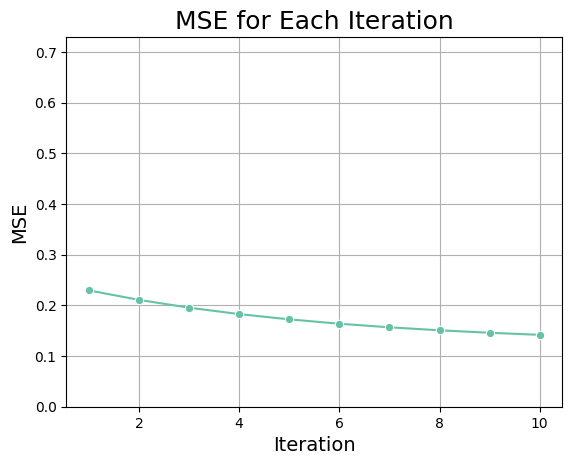

In [ ]:
gbrt1.plot_mse()

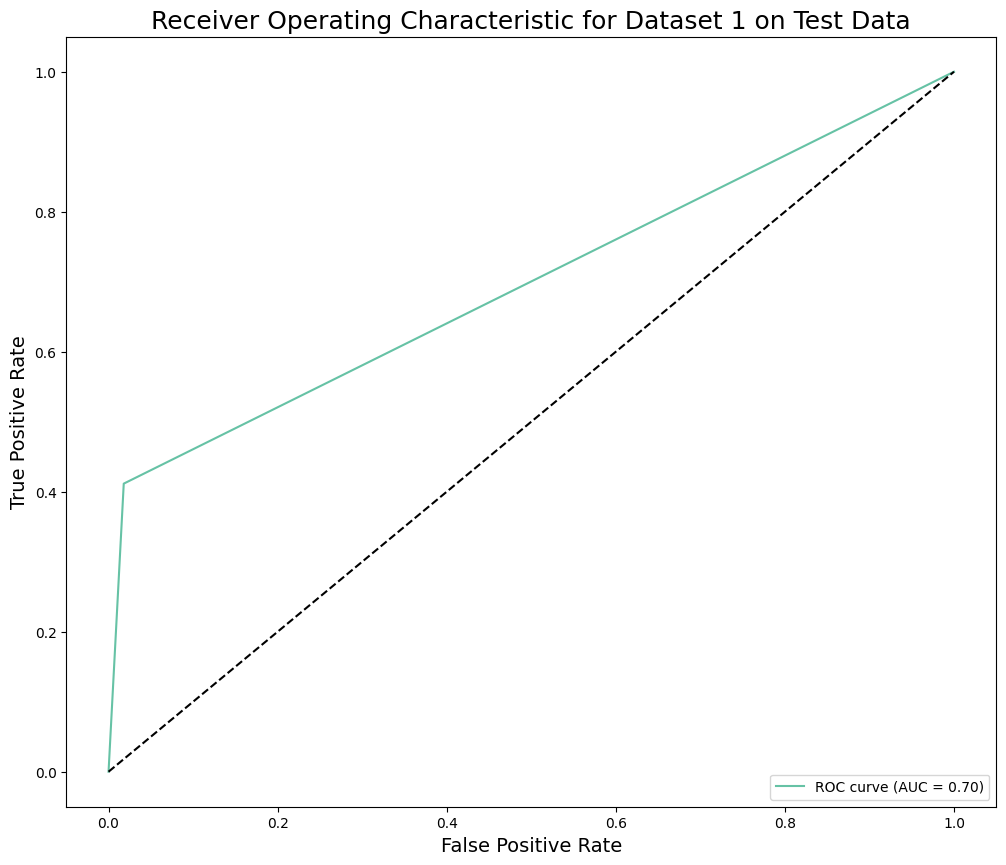

In [ ]:
gbrt1.roc(data=1)

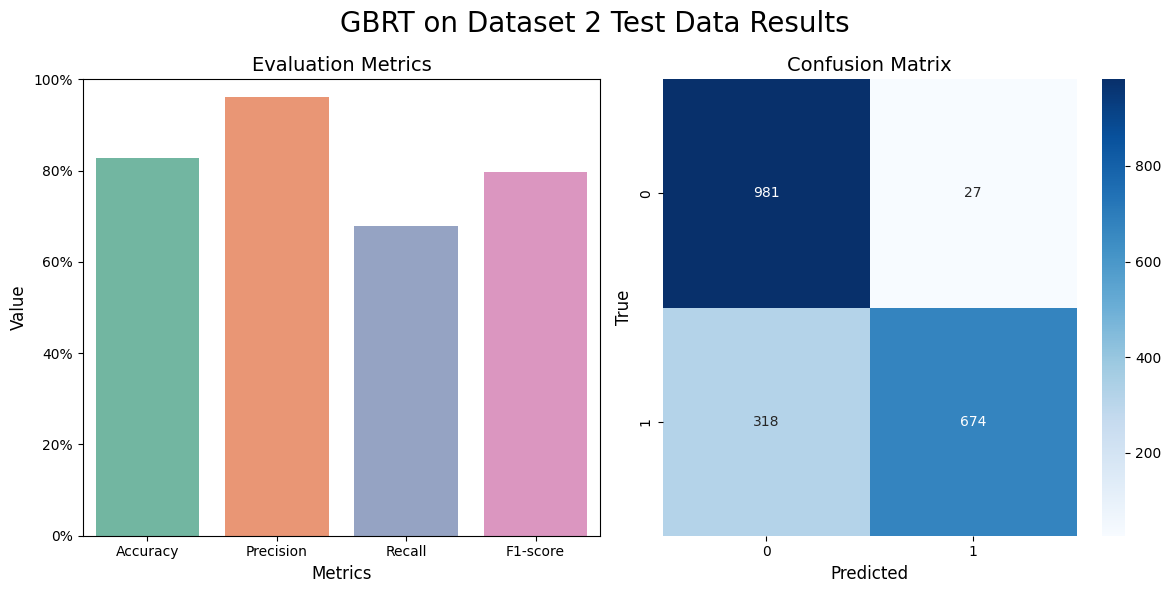

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1008
           1       0.96      0.68      0.80       992

    accuracy                           0.83      2000
   macro avg       0.86      0.83      0.82      2000
weighted avg       0.86      0.83      0.82      2000



In [ ]:
gbrt2 = GBRT()
gbrt2.boost(X2_train, y2_train, X2_test, y2_test)
gbrt2.print_results(data=2)

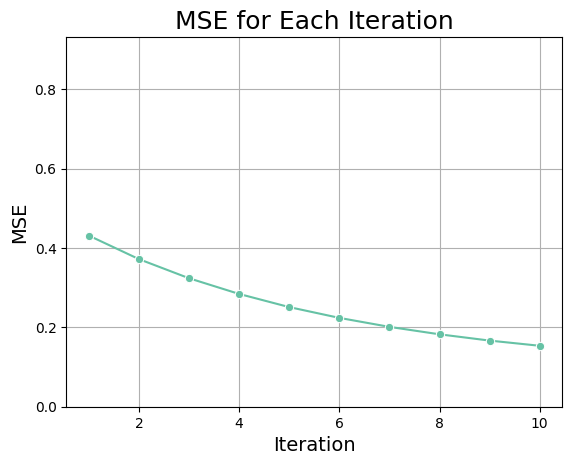

In [ ]:
gbrt2.plot_mse()

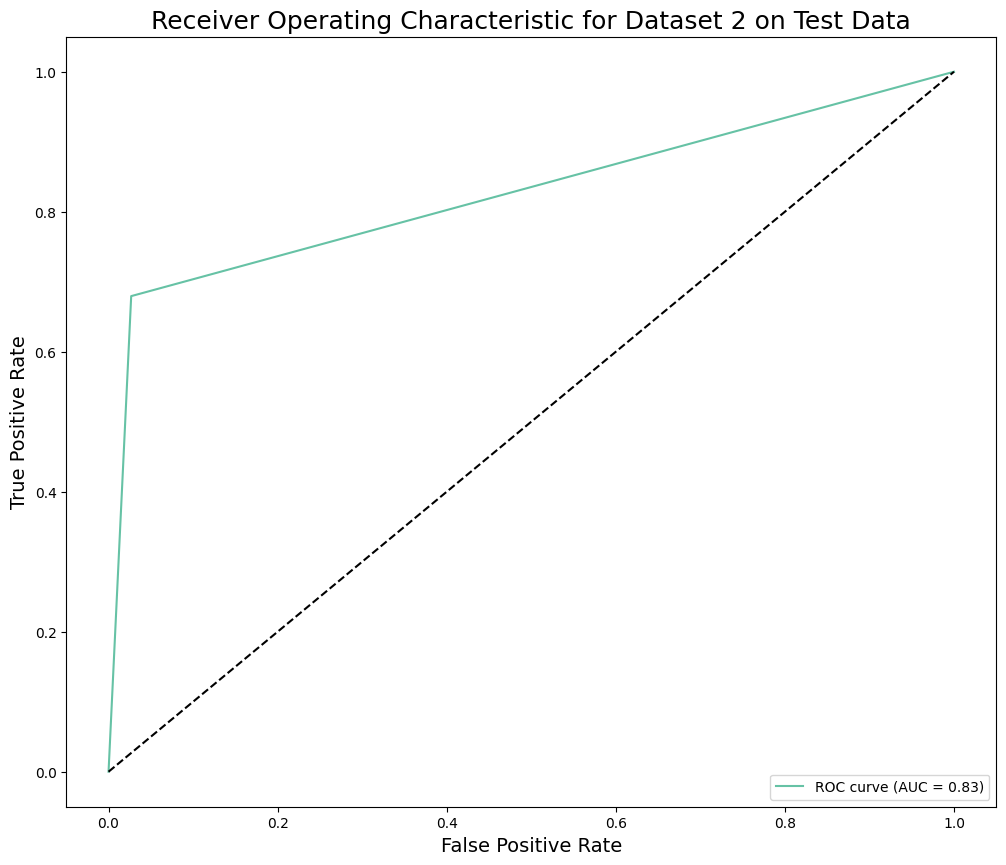

In [ ]:
gbrt2.roc(data=2)

Design and perform experiments to test the performance of your model. Present and discuss the results of the experiments.

In [ ]:
params = {
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [10, 500, 1000],
    'max_depth': [1, 2, 5],
    'min_samples_leaf': [1, 5, 10]
}

best_accuracy, best_params = gbrt1.grid_search(params)

Accuracy for learning_rate=0.01, n_estimators=10, max_depth=1, min_samples_leaf=1: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=1, min_samples_leaf=5: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=1, min_samples_leaf=10: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=2, min_samples_leaf=1: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=2, min_samples_leaf=5: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=2, min_samples_leaf=10: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=5, min_samples_leaf=1: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=5, min_samples_leaf=5: 72.3
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=5, min_samples_leaf=10: 72.3
Accuracy for learning_rate=0.01, n_estimators=500, max_depth=1, min_samples_leaf=1: 83.3
Accuracy for learning_rate=0.01, n_estimators=500, max_depth=1, min_samples_leaf=5: 83.3
Accuracy for learning_rate=

In [ ]:
print(f"For GBRT on Dataset 1:")
print(f"\nBest accuracy: {best_accuracy}")
print("Best parameters:", best_params)

For GBRT on Dataset 1:

Best accuracy: 96.39999999999999
Best parameters: {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'min_samples_leaf': 10}


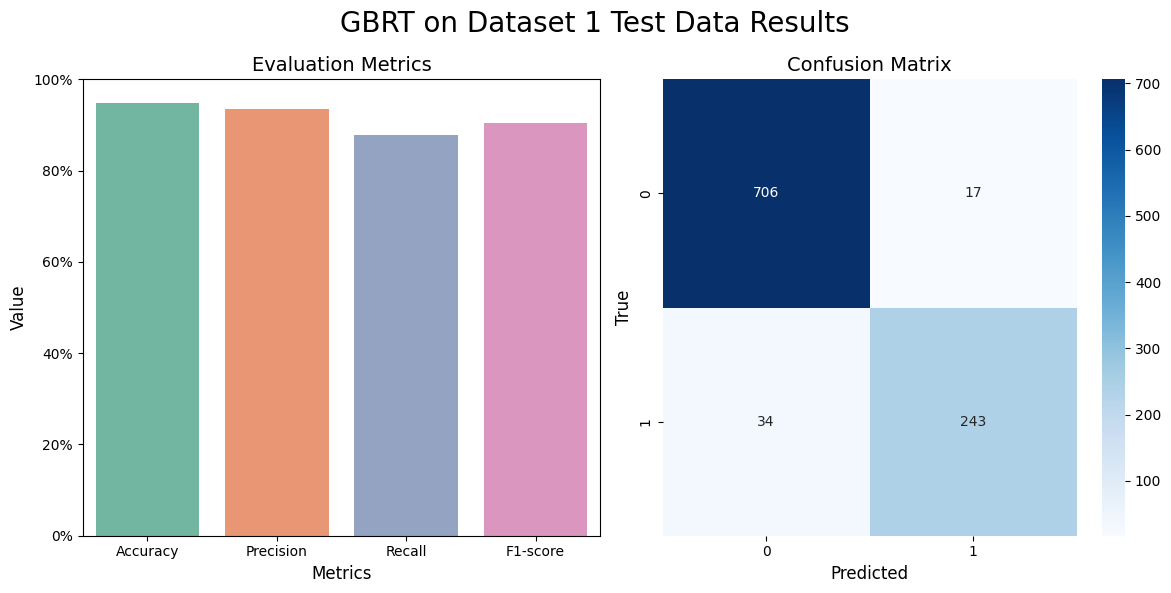

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       723
           1       0.93      0.88      0.91       277

    accuracy                           0.95      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
gbrt1.print_results(data=1)

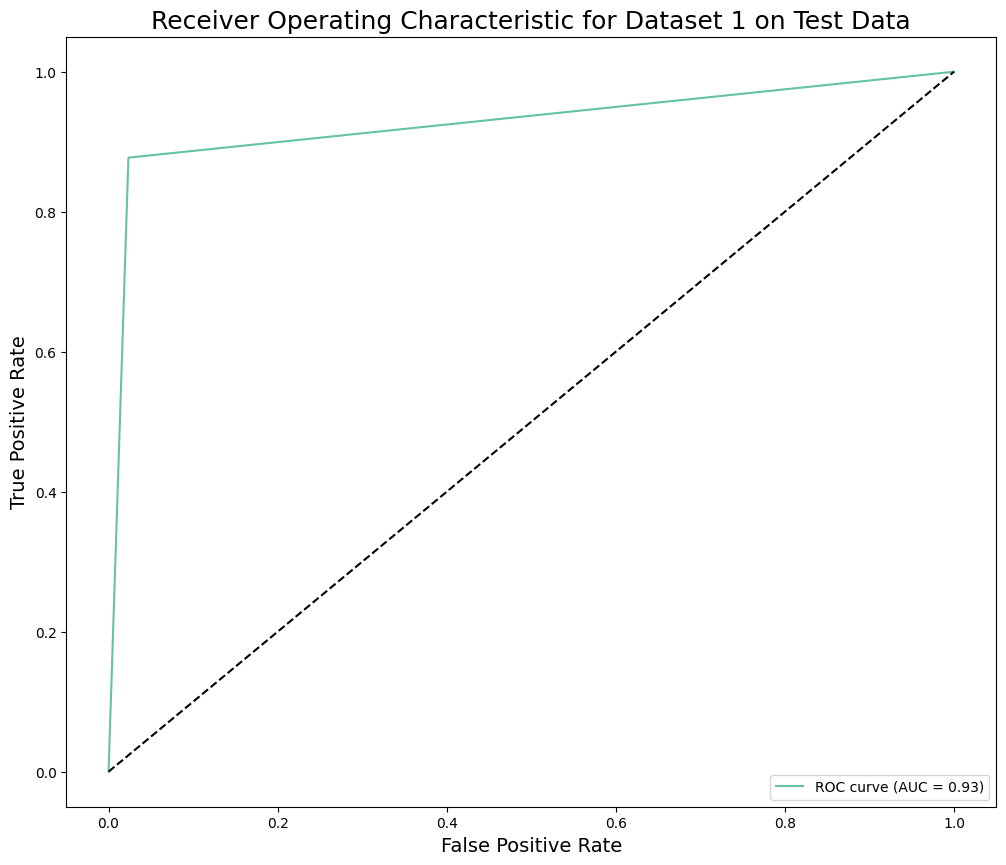

In [ ]:
gbrt1.roc(data=1)

In [ ]:
params = {
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [10, 500, 1000],
    'max_depth': [1, 2, 5],
    'min_samples_leaf': [1, 5, 10]
}

best_accuracy, best_params = gbrt2.grid_search(params)

Accuracy for learning_rate=0.01, n_estimators=10, max_depth=1, min_samples_leaf=1: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=1, min_samples_leaf=5: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=1, min_samples_leaf=10: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=2, min_samples_leaf=1: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=2, min_samples_leaf=5: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=2, min_samples_leaf=10: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=5, min_samples_leaf=1: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=5, min_samples_leaf=5: 50.4
Accuracy for learning_rate=0.01, n_estimators=10, max_depth=5, min_samples_leaf=10: 50.4
Accuracy for learning_rate=0.01, n_estimators=500, max_depth=1, min_samples_leaf=1: 92.25
Accuracy for learning_rate=0.01, n_estimators=500, max_depth=1, min_samples_leaf=5: 92.25
Accuracy for learning_rat

In [ ]:
print(f"For GBRT on Dataset 2:")
print(f"\nBest accuracy: {best_accuracy}")
print("Best parameters:", best_params)

For GBRT on Dataset 2:

Best accuracy: 96.95
Best parameters: {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 1, 'min_samples_leaf': 1}


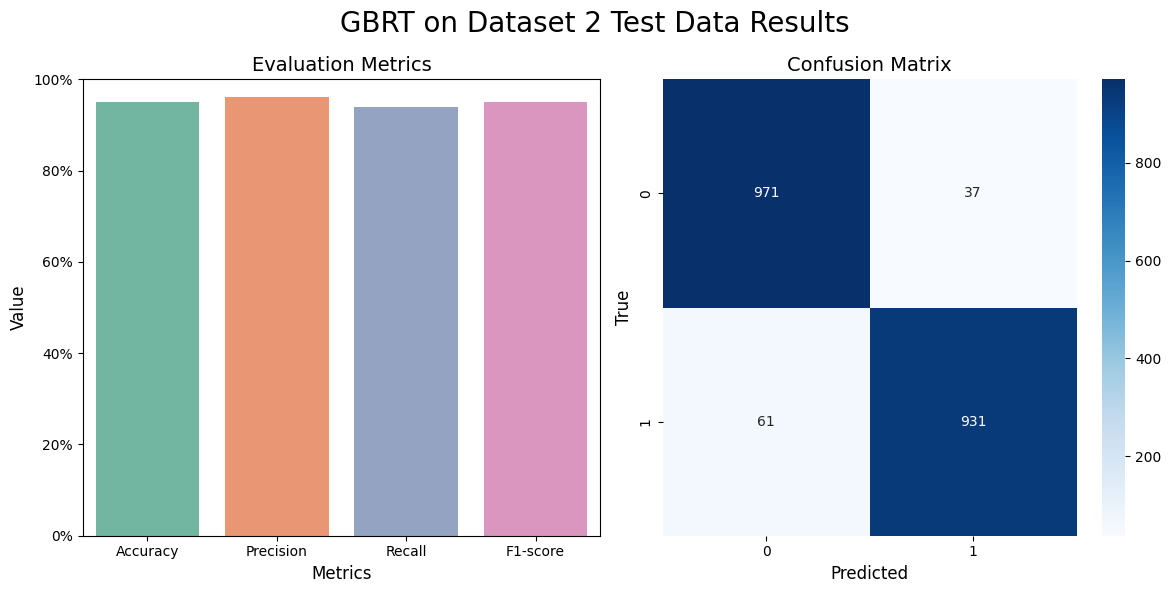

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1008
           1       0.96      0.94      0.95       992

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
gbrt2.print_results(data=2)

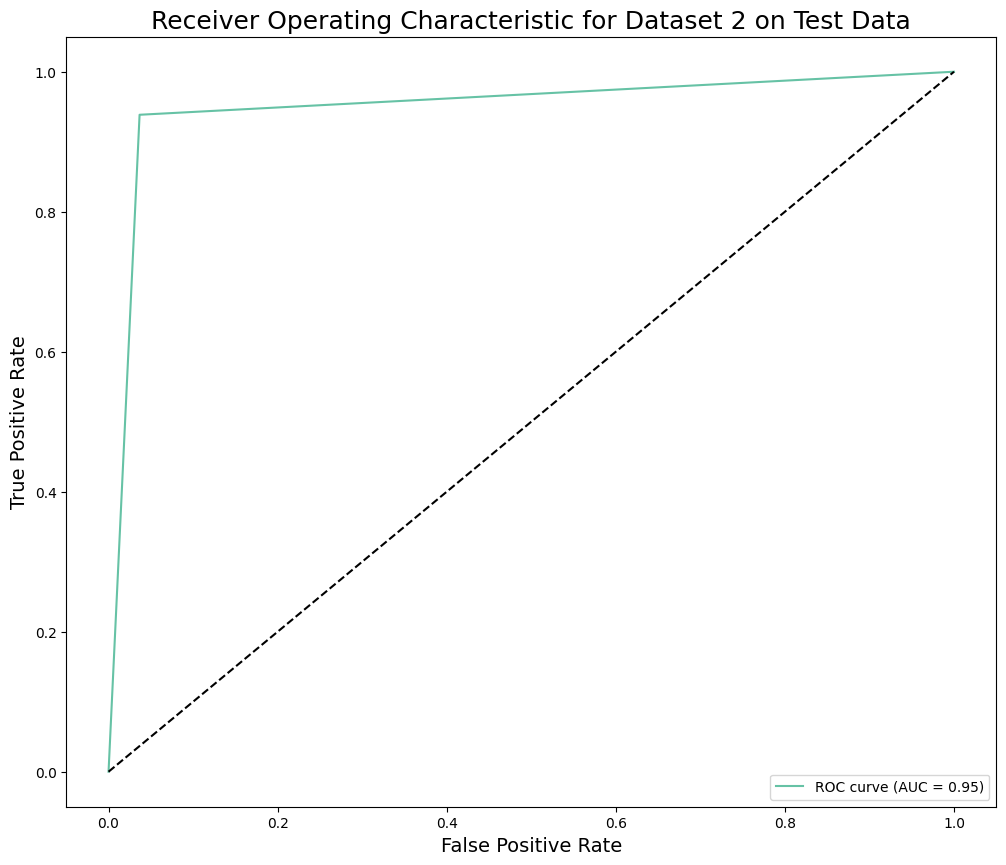

In [ ]:
gbrt2.roc(data=2)

### Part 2: AdaBoost

In [ ]:
y1_train = np.where(y1_train == 0, -1, 1)
y1_val = np.where(y1_val == 0, -1, 1)
y1_test = np.where(y1_test == 0, -1, 1)
y2_train = np.where(y2_train == 0, -1, 1)
y2_val = np.where(y2_val == 0, -1, 1)
y2_test = np.where(y2_test == 0, -1, 1)

#### Implement AdaBoost

In [ ]:
class DecisionStump:

  def __init__(self):
    self.polarity = 1
    self.feature_index = None
    self.threshold = None
    self.alpha = None

class AdaBoost:

  def __init__(self, estimators=5, learning_rate=1.0, test_data=None, test_target = None, val_data = None, val_target = None):
    self.estimators = estimators
    self.learning_rate = learning_rate
    self.test = test_data
    self.test_target = test_target
    self.val = val_data
    self.train_target = None
    self.train= None
    self.val_target = val_target
    self.estimator = None
    self.estimators_list = []
    self.weights = []
    self.mse = []
    self.accuracies = []
    self.iteration_times = []
    self.predictions = []
    self.errors = []
    self.best_accuracy = None
    self.best_params = None
    self.results = []
          
  def fit(self, X, y):
    self.train_target = y
    self.train = X
    self.estimators_list = []
    self.iteration_times = []
    self.mse = []
    self.accuracies = []
    # Initialize the weights of the training data
    weight = self._initialize_weights(X)
    self.weights = [weight]

    self.estimators_list, self.iteration_times = [], []
    for _ in range(self.estimators): # Iterate over the number of estimators
      start_time = time.time()

      # Train base learner using weighted training data
      estimator, weight = self._boosting_step(X, y, weight)
      self.iteration_times.append(time.time() - start_time)
      self.estimators_list.append(estimator)
      self.weights.append(weight)

      # Obtain predictions of base learner 
      y_pred = self.predict(self.val)
      self.mse.append(self._compute_mse(self.val_target, y_pred))
      self.accuracies.append(accuracy_score(self.val_target, y_pred) * 100)

  def predict(self, X):
    # Determine predictions by combining prediction of all base learners
    self.predictions = np.sign(np.sum([estimator.alpha * np.where(estimator.polarity * X[:, estimator.feature_index] < estimator.polarity * estimator.threshold, -1, 1) for estimator in self.estimators_list], axis=0))
    return self.predictions
  
  def print_results(self, data=None):
    # Determine accuracy, precision, recall, f1 scores
    accuracy = accuracy_score(self.test_target, self.predictions) * 100
    precision = precision_score(self.test_target, self.predictions, pos_label=1) * 100
    recall = recall_score(self.test_target, self.predictions, pos_label=1) * 100
    f1 = f1_score(self.test_target, self.predictions, pos_label=1) * 100

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    values = [accuracy, precision, recall, f1]
    colors = sns.color_palette('Set2')[:len(metrics)]
    
    # Plot results as bar plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(x=metrics, y=values, palette=colors, ax=ax1)
    ax1.set_xlabel('Metrics', size=12)
    ax1.set_ylabel('Value', size=12)
    ax1.set_title('Evaluation Metrics', size=14)
    ax1.set_ylim(0, 100)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    
    # Plot results are matrix
    cm = confusion_matrix(self.test_target, self.predictions)
    labels = np.unique(self.test_target)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_xlabel('Predicted', size=12)
    ax2.set_ylabel('True', size=12)
    ax2.set_title(f'Confusion Matrix', size=14)

    fig.suptitle(f'AdaBoost on Dataset {data} Test Data Results', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    print(classification_report(self.test_target, self.predictions))
      
  def roc(self, data):
    # Obtain vaues for ROC curve
    fpr, tpr, thresholds = roc_curve(self.test_target, self.predictions)
    roc_auc = auc(fpr, tpr)

    # plot line graph
    plt.figure(figsize=(12, 10))
    sns.lineplot(x=fpr, y=tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.title(f'Receiver Operating Characteristic for Dataset {data} on Test Data', size=18)
    plt.legend(loc='lower right')
    plt.show()

  
  def plot_mse_and_accuracies(self, data=None):
    # Plot MSE and accuracy per iteration
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    sns.lineplot(x=range(1, self.estimators + 1), y=self.mse, marker='o', ax=ax1)
    ax1.set_xlabel('Iteration', size=14)
    ax1.set_ylabel('MSE', size=14)
    ax1.set_title(f'MSE for Each Iteration of AdaBoost on Dataset {data} Validation Data', size=18)
    ax1.set_ylim(0, max(self.mse)+.5)
    ax1.grid(True)
    
    sns.lineplot(x=range(1, self.estimators + 1), y=self.accuracies, marker='o', ax=ax2)
    ax2.set_xlabel('Iteration', size=14)
    ax2.set_ylabel('Accuracy', size=14)
    ax2.set_title(f'Prediction Accuracy for Each Iteration of AdaBoost on Dataset {data} Validation Data', size=18)
    ax2.set_ylim(0, 100)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
      
  def plot_iteration_times(self, data = None):
    plt.figure(figsize=(12, 10))
    plt.plot(range(1, self.estimators + 1), self.iteration_times, 'o-')
    plt.xlabel('Iteration', size=14)
    plt.ylabel('Time (seconds)', size=14)
    plt.title(f'Iteration Time for AdaBoost on Dataset {data}', size=18)
    plt.grid(True)
    plt.show()

  def grid_search(self, param_grid):
    param_combinations = itertools.product(*param_grid.values())
    best_accuracy = 0.0
    best_params = {}
    for params in param_combinations:
      param_dict = dict(zip(param_grid.keys(), params))
      self.estimators = param_dict['estimators']
      self.learning_rate = param_dict['learning_rate']
      self.fit(self.train, self.train_target)
      accuracy = accuracy_score(self.test_target, self.predict(self.test))
      result = (param_dict['learning_rate'], param_dict['estimators'], accuracy)
      self.results.append(result)

      param_string = ', '.join([f"{key}={val}" for key, val in param_dict.items()])
      print(f"Accuracy for {param_string}: {accuracy}")

      if accuracy > best_accuracy:
        self.best_accuracy = accuracy
        self.best_params = param_dict

  def _boosting_step(self, X, y, weight):
    estimator = DecisionStump()
    minimum_error = np.inf

    # iterate over each feautre, threshold and polarity 
    for feature in range(X.shape[1]):
      for threshold in (np.sort(np.unique(X[:, feature]))[:-1] + np.sort(np.unique(X[:, feature]))[1:]) / 2:
        for polarity in [1, -1]:
          y_pred = np.ones(len(y))

          # Update predicted labels based on condition (assign -1 to prediction if true)
          y_pred[polarity * X[:, feature] < polarity * threshold] = -1

          # Compute weighted error
          err = self._compute_weighted_error(y, y_pred, weight)
          estimator.polarity, estimator.threshold, estimator.feature_index, minimum_error = (polarity, threshold, feature, err) if err < minimum_error else (estimator.polarity, estimator.threshold, estimator.feature_index, minimum_error)
  
    # Compute alpha assigned to base learner using minimum error
    estimator.alpha = self._compute_alpha(minimum_error)
    # Generate predictions for current learner
    y_pred = self._predict_stump(X, estimator.feature_index, estimator.threshold, estimator.polarity)
    # Updare sample weights based on alpga and prediction
    weight = self._update_weights(estimator.alpha, y, y_pred, weight)
    return estimator, weight
          
  def _predict_stump(self, X, feature_index, threshold, polarity):
    # Applies splitting rule to make predictions
    y_pred = np.ones(len(X))
    y_pred[polarity * X[:, feature_index] < polarity * threshold] = -1
    return y_pred
  
  def _initialize_weights(self, X):
    # Initializes sampe weights
    return np.full(X.shape[0], (1 / X.shape[0]))

  def _compute_weighted_error(self, y, y_pred, weights):
    # Sum weights of misclassified samples and divide by total weight to calculate weighted error
    return np.sum(weights * (y != y_pred)) / np.sum(weights)

  def _compute_alpha(self, error):
    # Compure the value of alpha based on error rate 
    return 0.5 * np.log((1.0 - error + 1e-10) / (error + 1e-10))

  def _update_weights(self, alpha, y, y_pred, weights):
    # Update weights assiend to ech sample using exponential factor
    return weights * np.exp(self.learning_rate * alpha * (np.not_equal(y, y_pred)).astype(int))
  
  def _compute_mse(self, y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

Demonstrate your AdaBoost model on the datasets you generated

### Dataset 1

In [ ]:
ada1 = AdaBoost(test_data= X1_test, test_target = y1_test, val_data = X1_val, val_target=y1_val)
ada1.fit(X1_train, y1_train)
final_predictions = ada1.predict(X1_test)

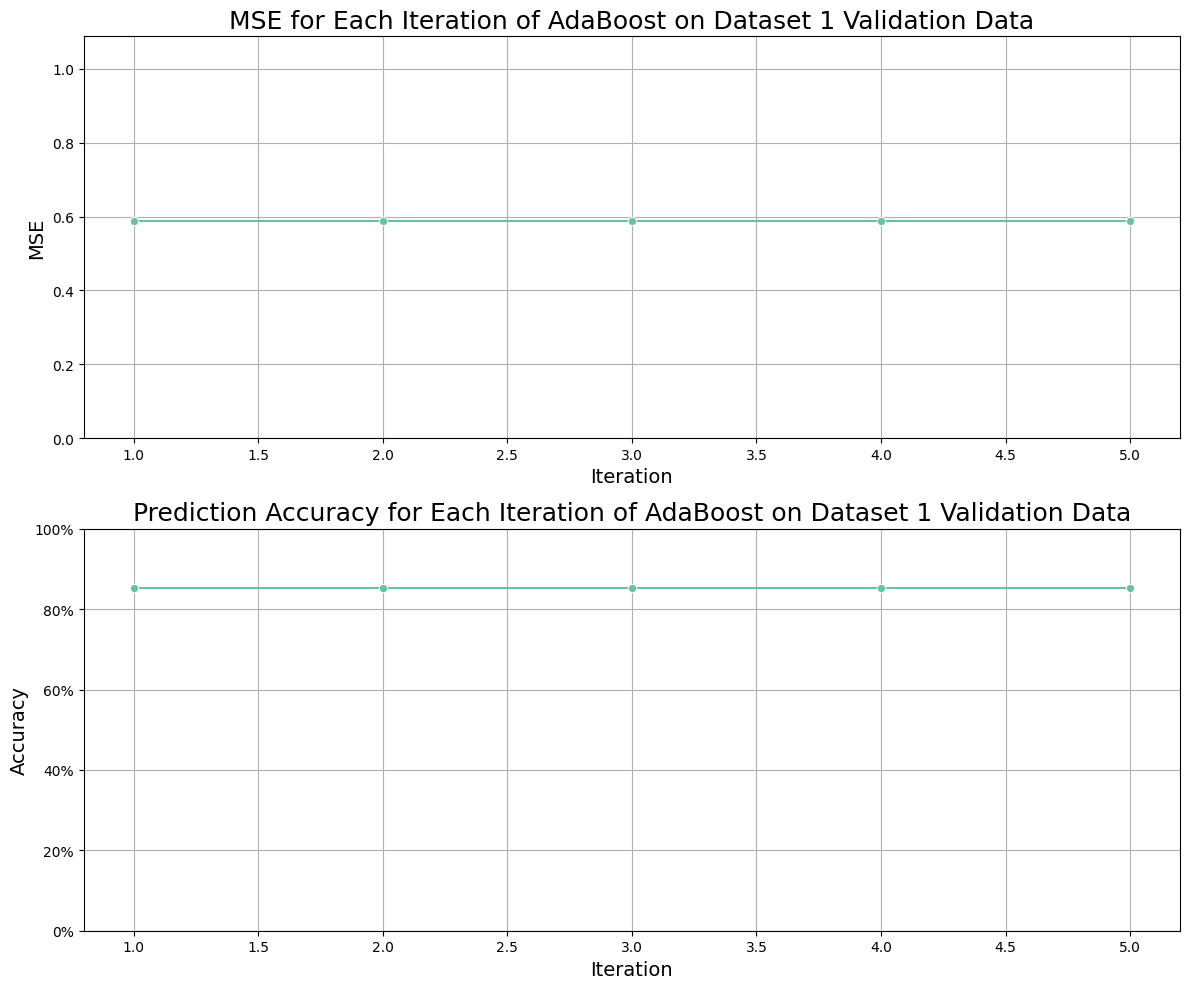

In [ ]:
ada1.plot_mse_and_accuracies(data=1)

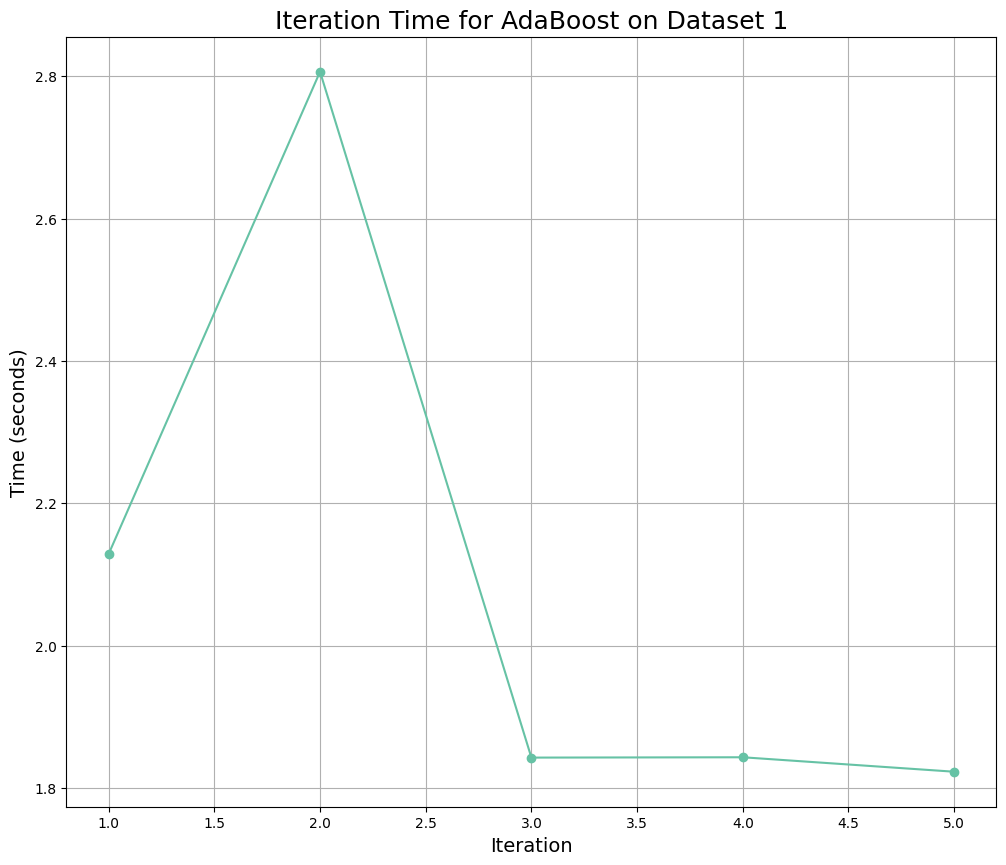

In [ ]:
ada1.plot_iteration_times(data=1)

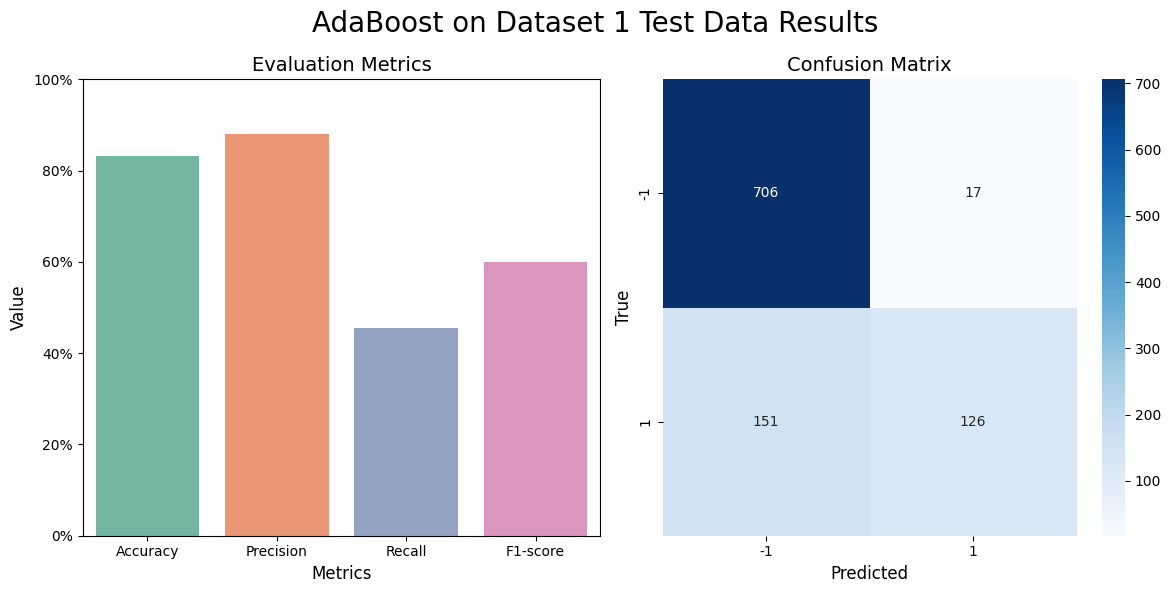

              precision    recall  f1-score   support

          -1       0.82      0.98      0.89       723
           1       0.88      0.45      0.60       277

    accuracy                           0.83      1000
   macro avg       0.85      0.72      0.75      1000
weighted avg       0.84      0.83      0.81      1000



In [ ]:
ada1.print_results(data=1)

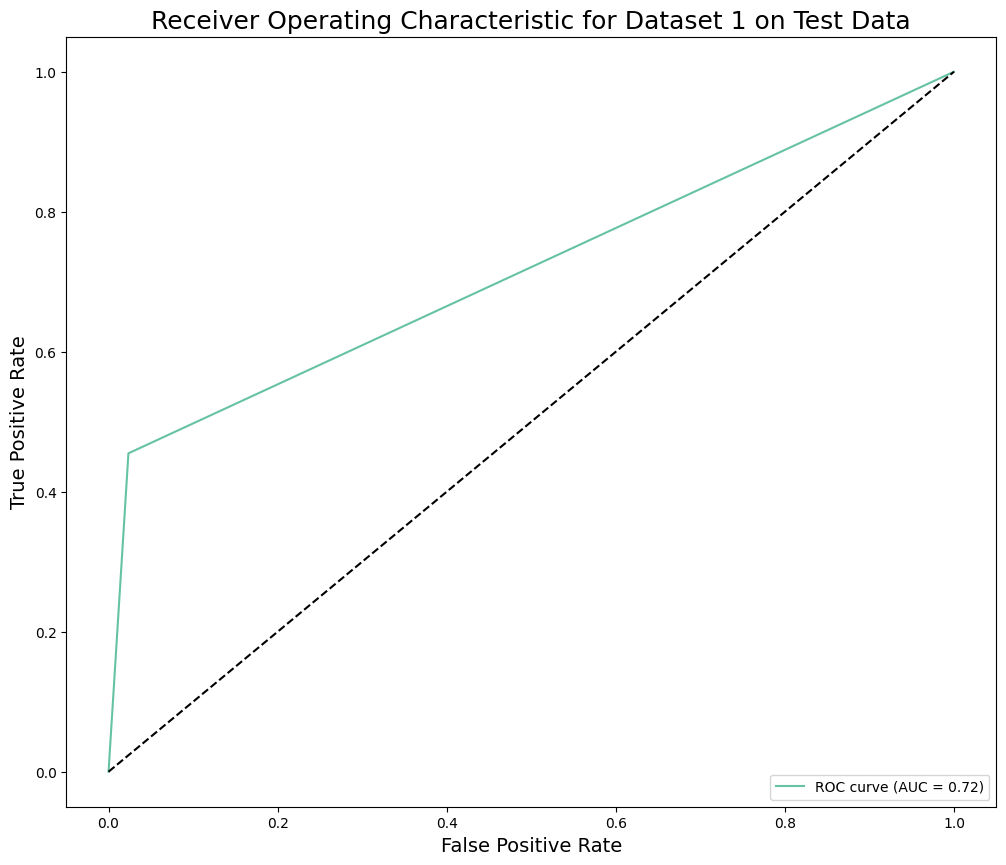

In [ ]:
ada1.roc(data=1)

### Dataset 2

In [ ]:
ada2 = AdaBoost(test_data= X2_test, test_target = y2_test, val_data = X2_val, val_target=y2_val)
ada2.fit(X2_train, y2_train)
final_predictions2 = ada2.predict(X2_test)

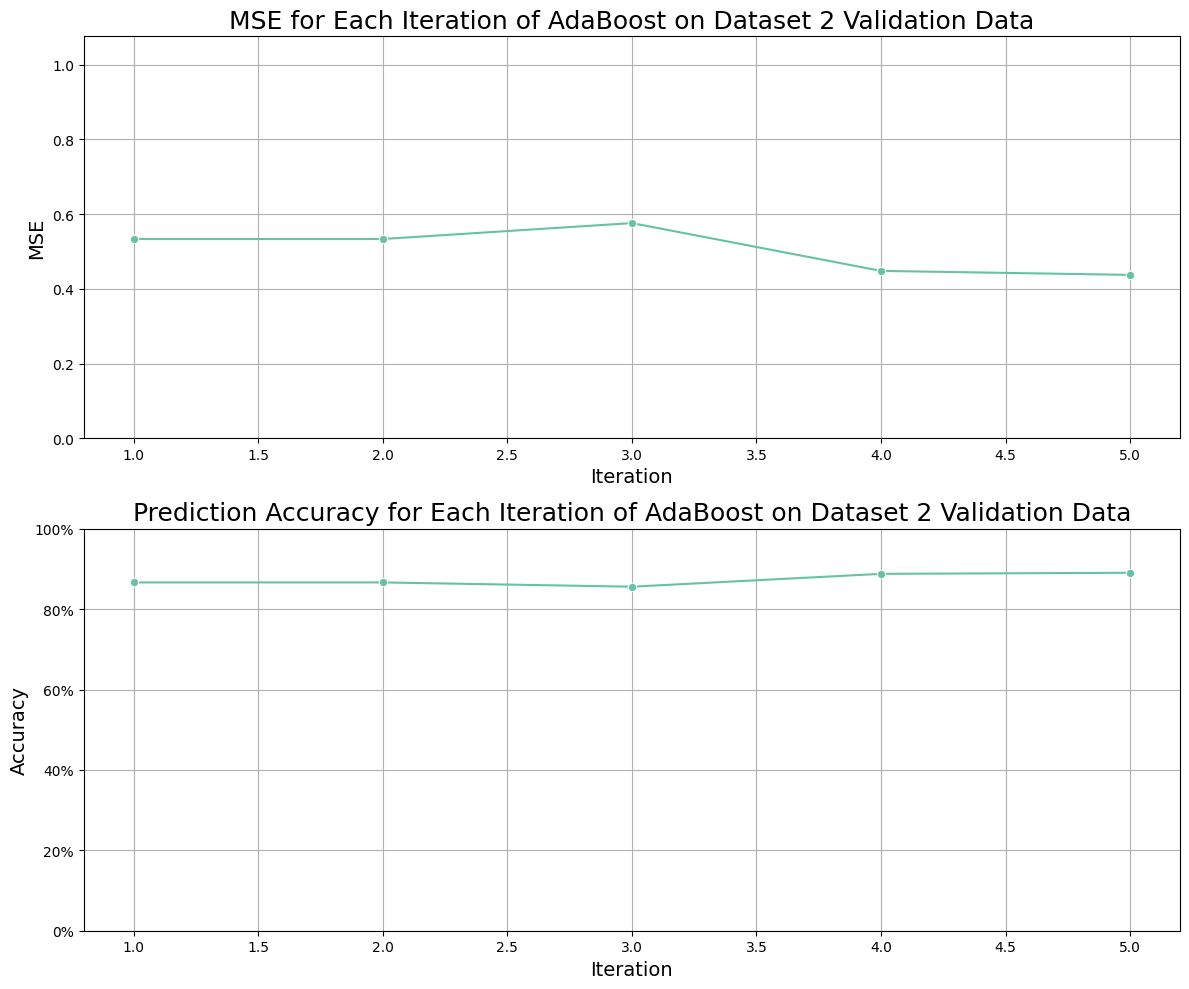

In [ ]:
ada2.plot_mse_and_accuracies(data=2)

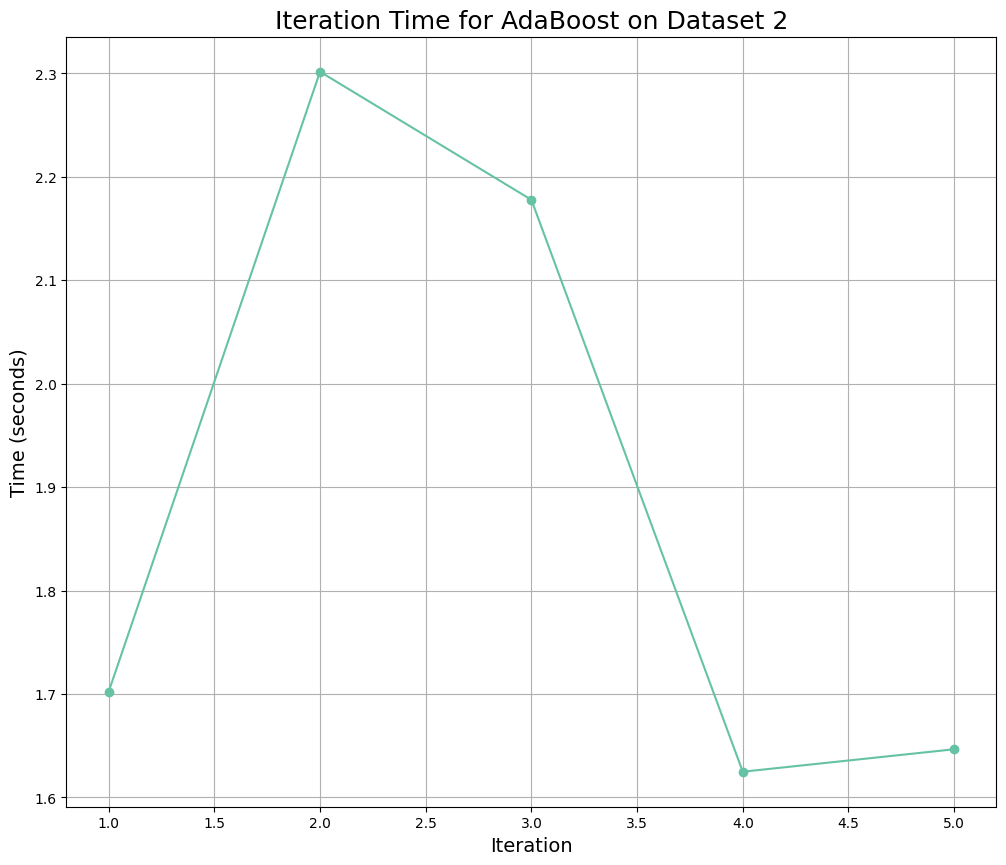

In [ ]:
ada2.plot_iteration_times(data=2)

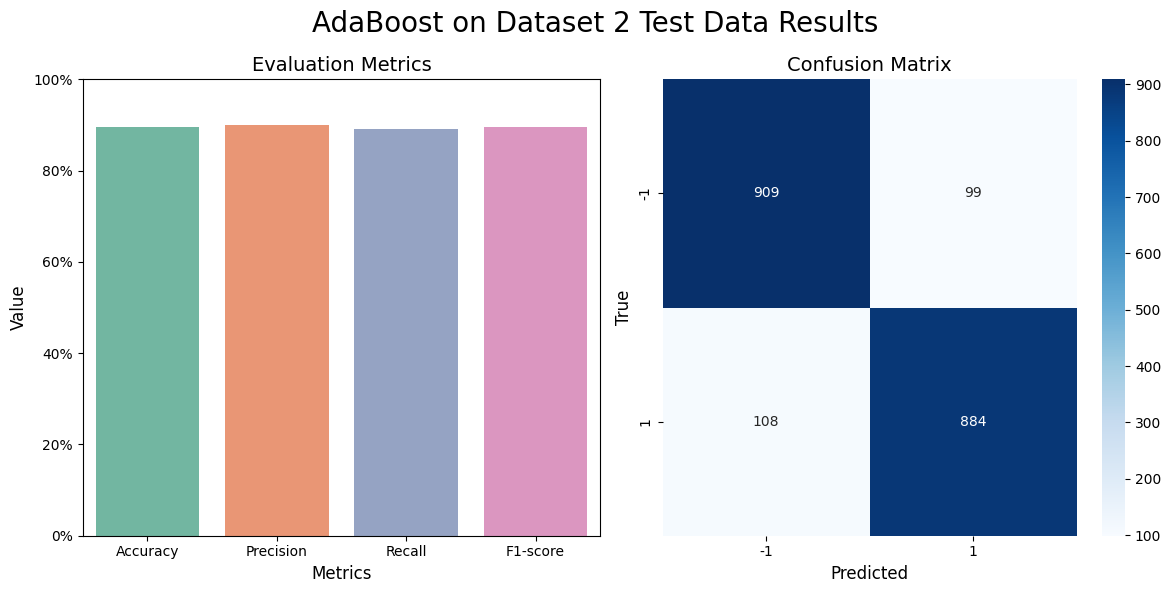

              precision    recall  f1-score   support

          -1       0.89      0.90      0.90      1008
           1       0.90      0.89      0.90       992

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [ ]:
ada2.print_results(data=2)

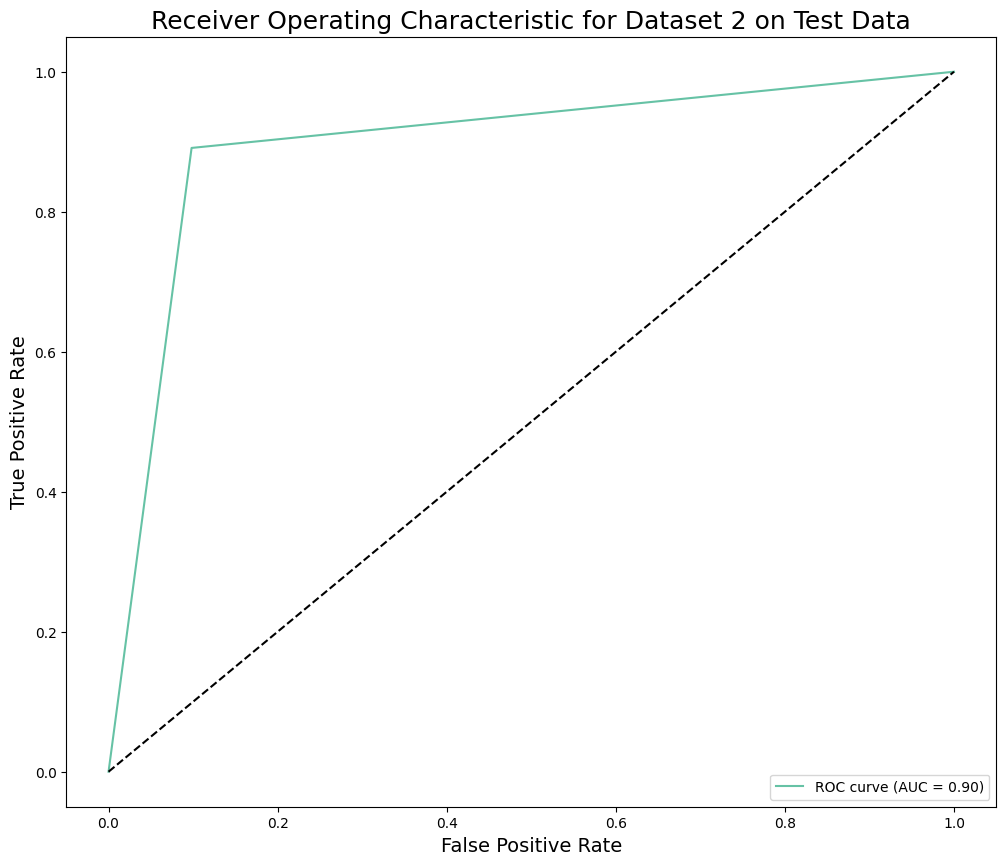

In [ ]:
ada2.roc(data=2)

Design and perform experiments to test the performance of your model. Present and discuss the results of the experiments

In [ ]:
params = {
    'estimators': [5, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}

ada1.grid_search(params)

Accuracy for estimators=5, learning_rate=0.01: 0.832
Accuracy for estimators=5, learning_rate=0.1: 0.832
Accuracy for estimators=5, learning_rate=1.0: 0.832
Accuracy for estimators=50, learning_rate=0.01: 0.832
Accuracy for estimators=50, learning_rate=0.1: 0.832
Accuracy for estimators=50, learning_rate=1.0: 0.842
Accuracy for estimators=100, learning_rate=0.01: 0.832
Accuracy for estimators=100, learning_rate=0.1: 0.84
Accuracy for estimators=100, learning_rate=1.0: 0.849


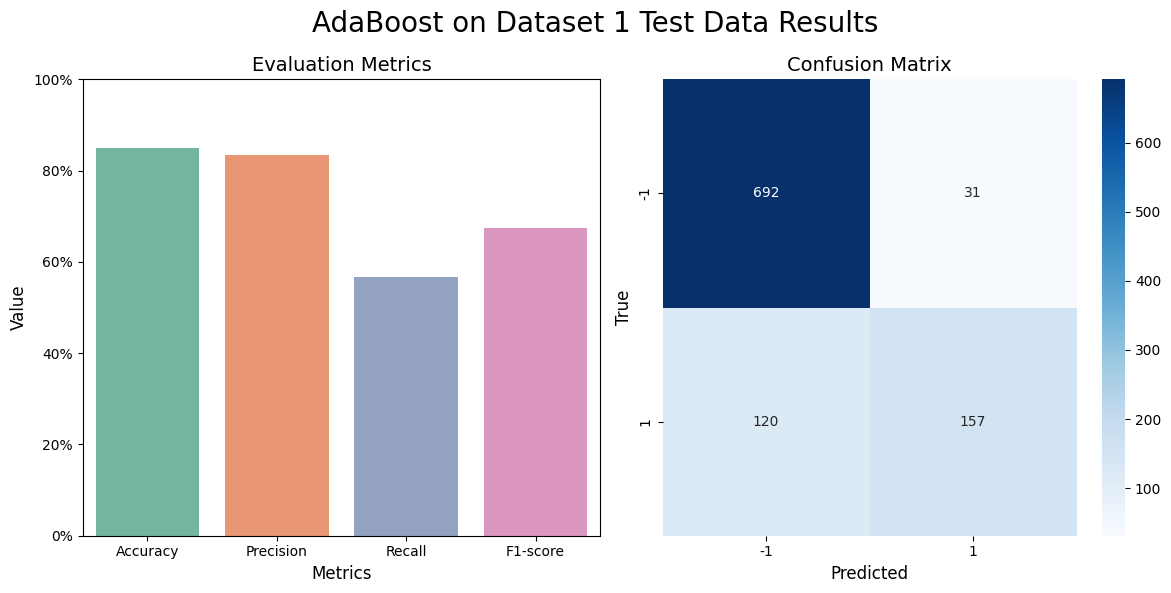

              precision    recall  f1-score   support

          -1       0.85      0.96      0.90       723
           1       0.84      0.57      0.68       277

    accuracy                           0.85      1000
   macro avg       0.84      0.76      0.79      1000
weighted avg       0.85      0.85      0.84      1000



In [ ]:
ada1.print_results(data=1)

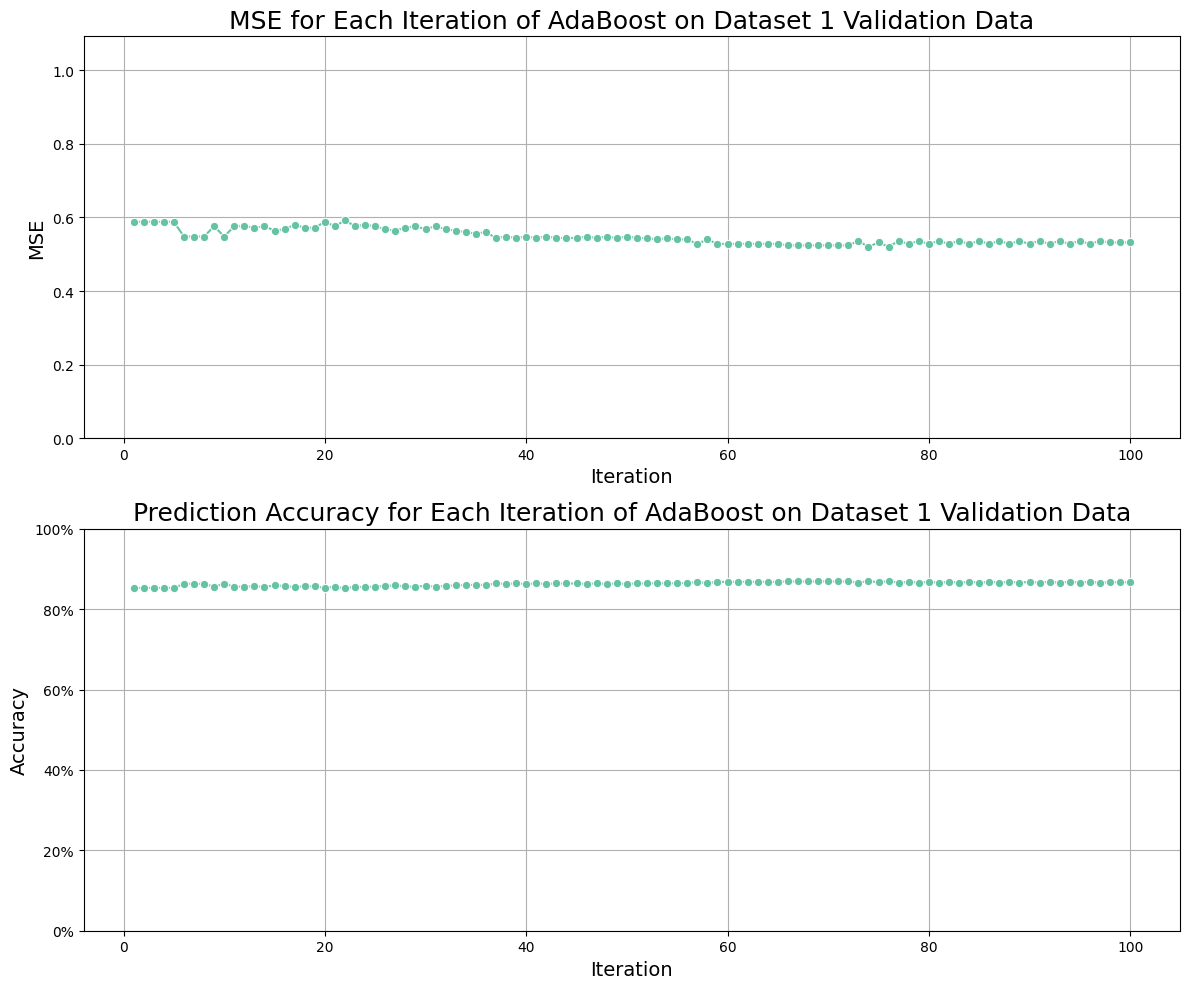

In [ ]:
ada1.plot_mse_and_accuracies(data=1)

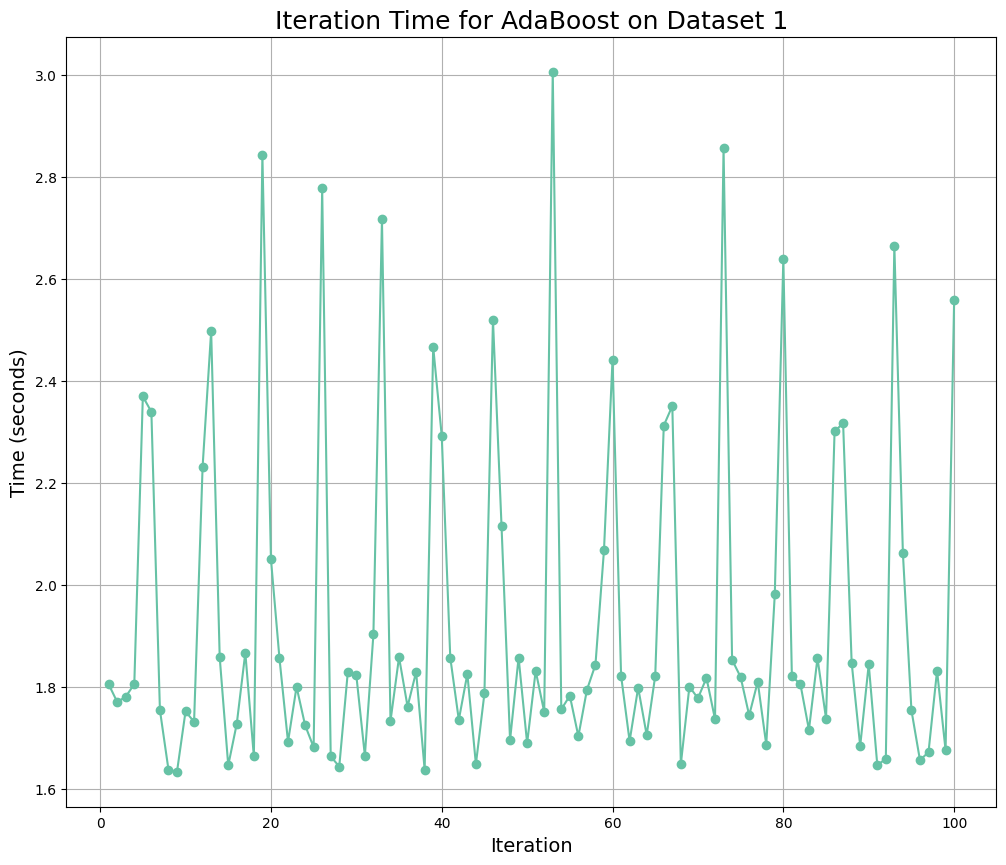

In [ ]:
ada1.plot_iteration_times(data=1)

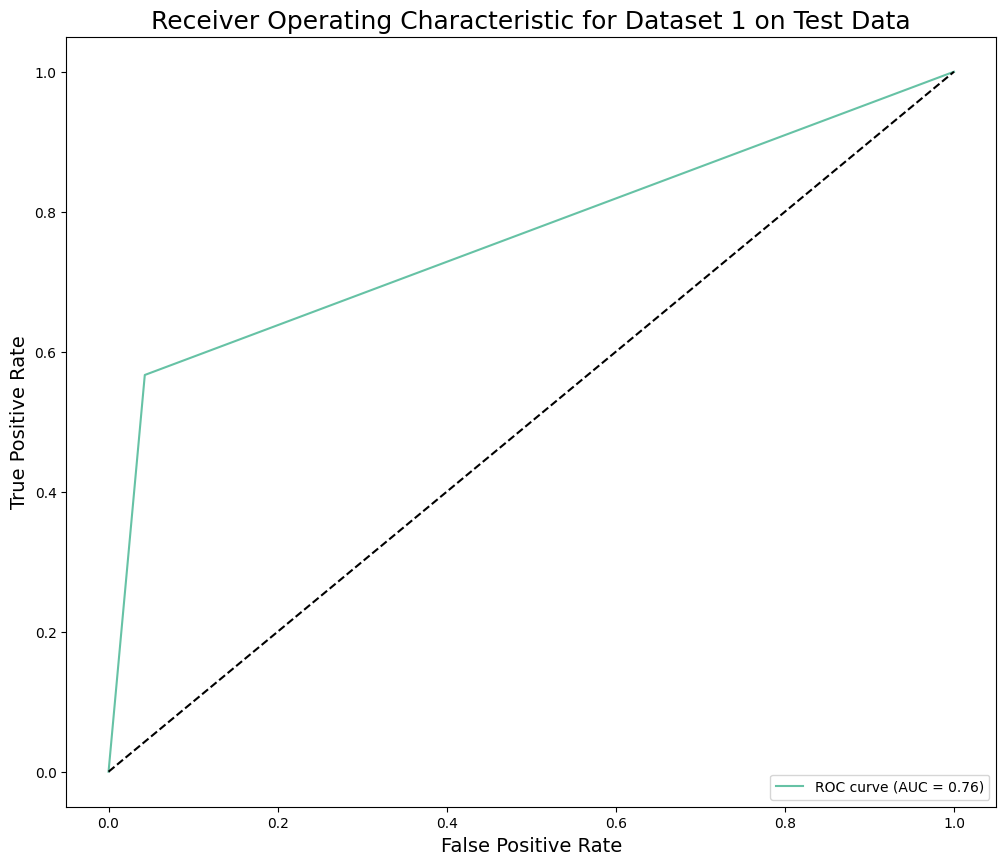

In [ ]:
ada1.roc(data=1)

In [ ]:
params = {
    'estimators': [5, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}

ada2.grid_search(params)

Accuracy for estimators=5, learning_rate=0.01: 0.8495
Accuracy for estimators=5, learning_rate=0.1: 0.85
Accuracy for estimators=5, learning_rate=1.0: 0.8965
Accuracy for estimators=50, learning_rate=0.01: 0.8495
Accuracy for estimators=50, learning_rate=0.1: 0.887
Accuracy for estimators=50, learning_rate=1.0: 0.957
Accuracy for estimators=100, learning_rate=0.01: 0.857
Accuracy for estimators=100, learning_rate=0.1: 0.9195
Accuracy for estimators=100, learning_rate=1.0: 0.9645


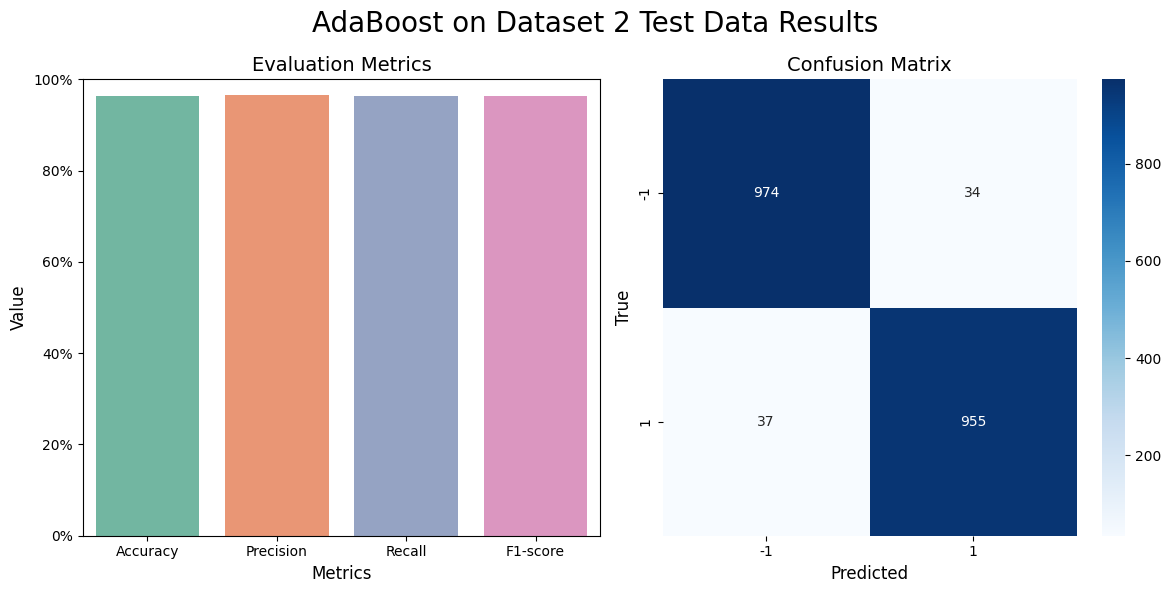

              precision    recall  f1-score   support

          -1       0.96      0.97      0.96      1008
           1       0.97      0.96      0.96       992

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [ ]:
ada2.print_results(data=2)

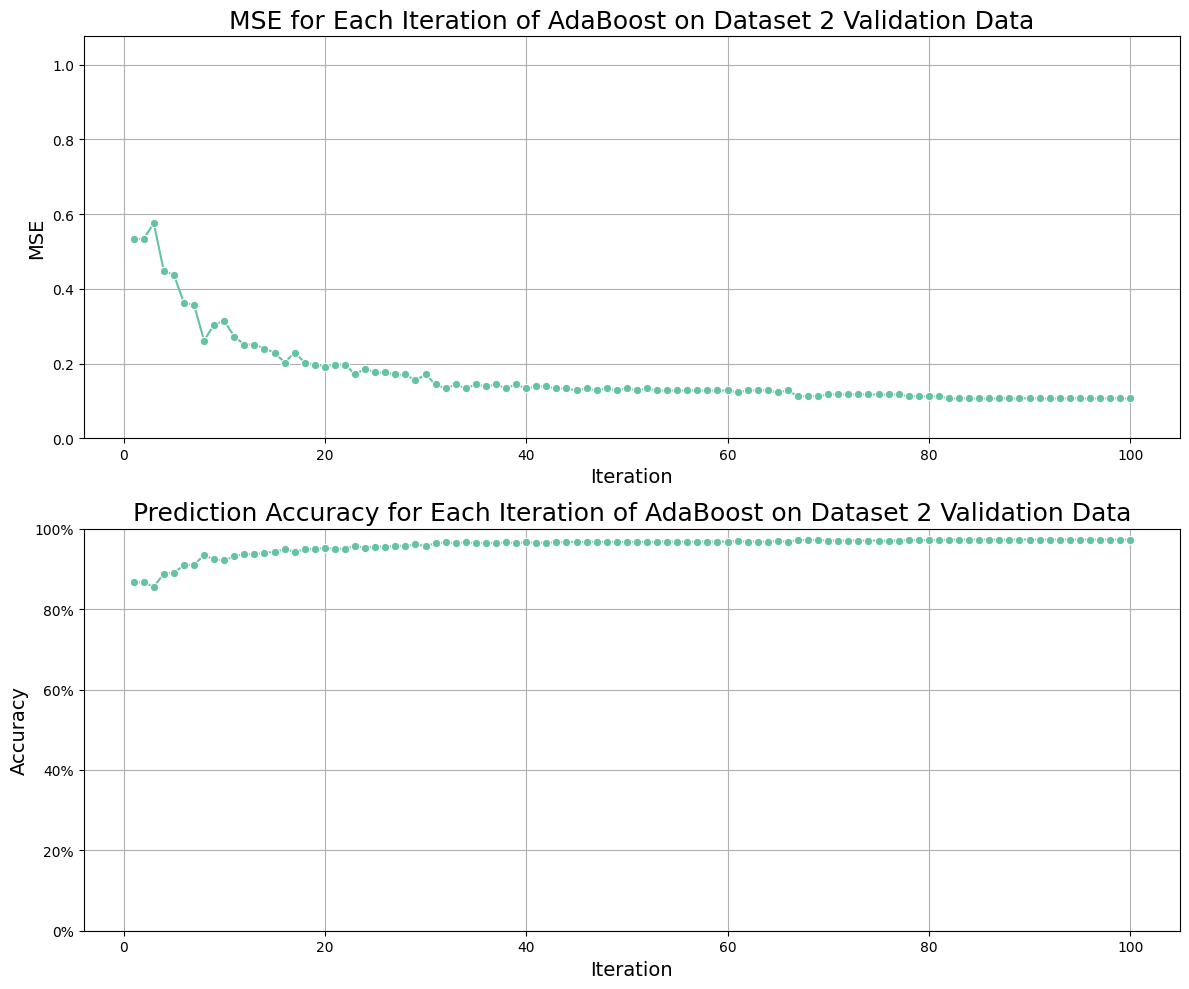

In [ ]:
ada2.plot_mse_and_accuracies(data=2)

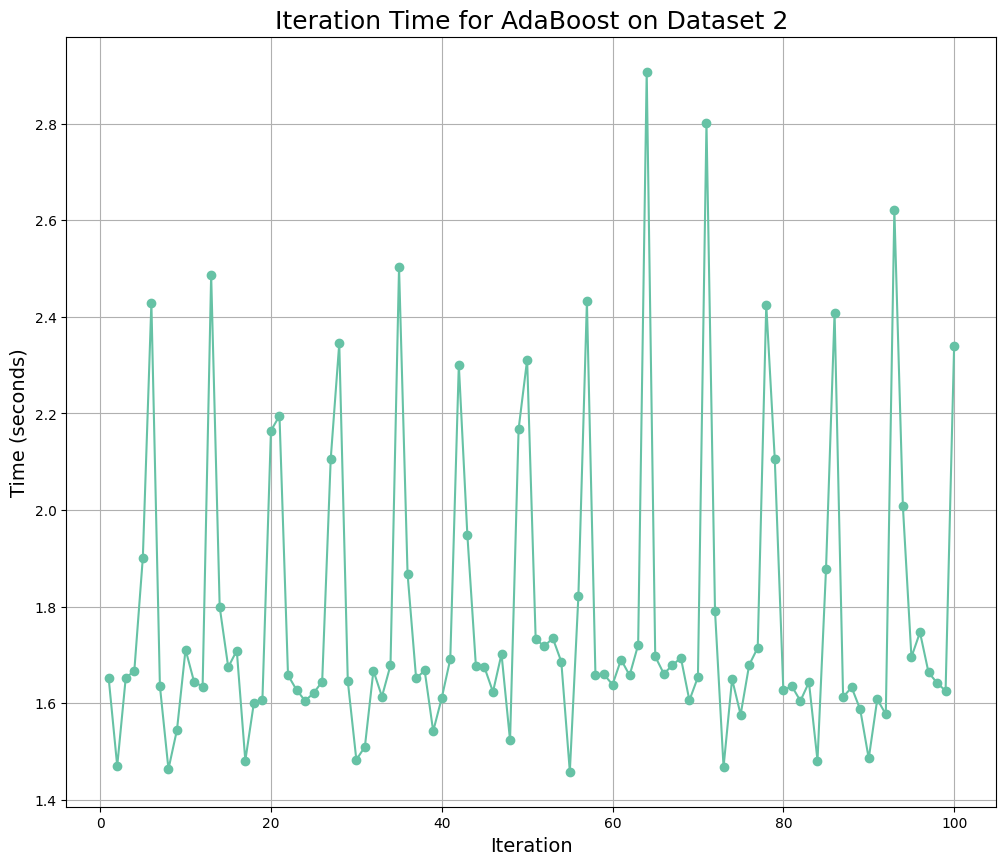

In [ ]:
ada2.plot_iteration_times(data=2)

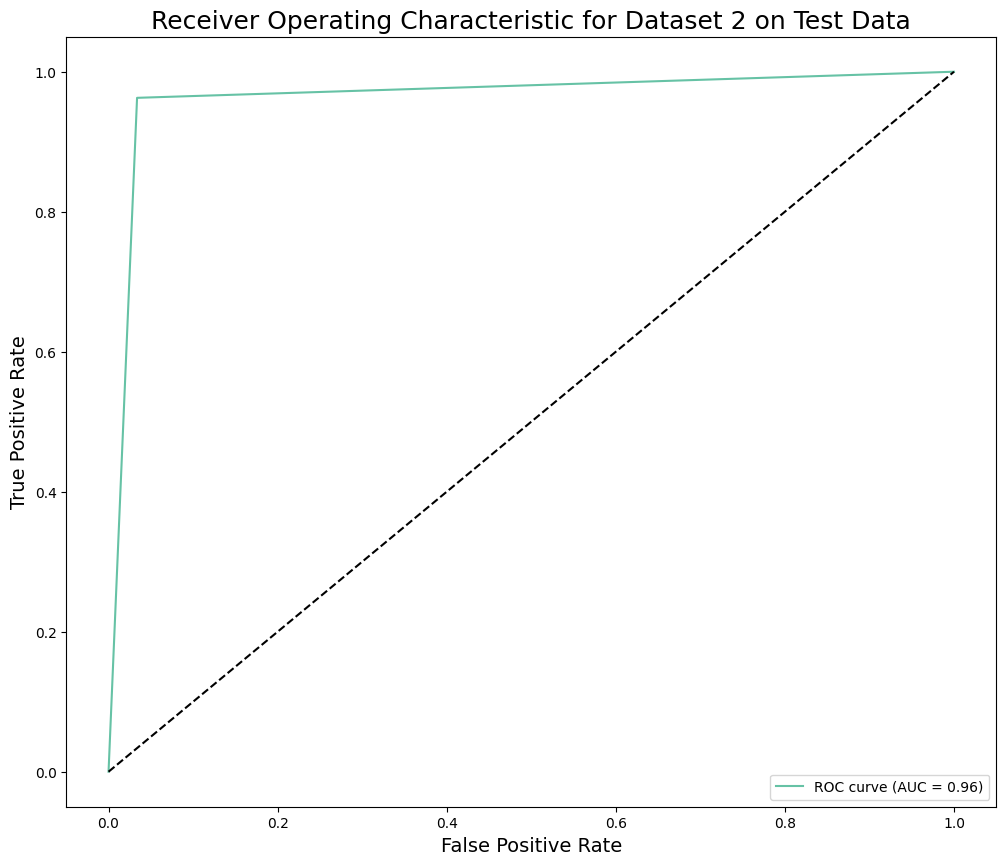

In [ ]:
ada2.roc(data=2)

In [ ]:
num_estimators = len(params['estimators'])
num_lrs = len(params['learning_rate'])

accuracies1 = [result[2] for result in ada1.results]
accuracies1 = np.array([accuracy * 100 for accuracy in accuracies1]).reshape(num_estimators, num_lrs)
accuracies2 = [result[2] for result in ada2.results]
accuracies2 = np.array([accuracy * 100 for accuracy in accuracies2]).reshape(num_estimators, num_lrs)

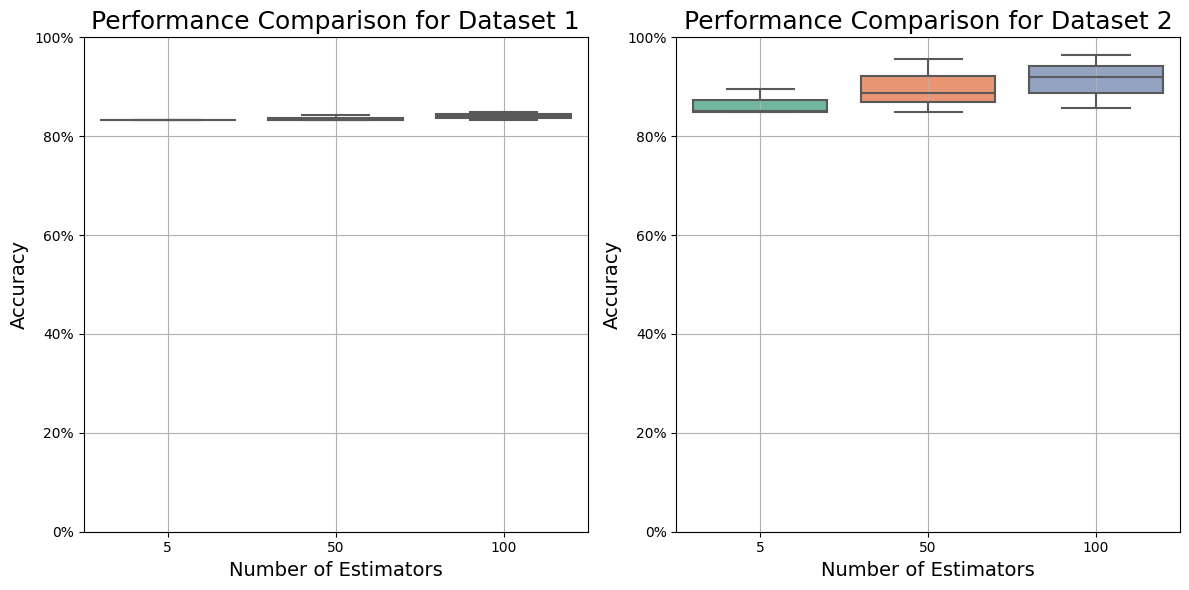

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=accuracies1.T, palette="Set2", ax=ax1)
ax1.set_xlabel('Number of Estimators', size=14)
ax1.set_ylabel('Accuracy', size=14)
ax1.set_title('Performance Comparison for Dataset 1', size=18)
ax1.set_ylim(0, 100)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax1.set_xticklabels(params['estimators']) 
ax1.grid(True)

sns.boxplot(data=accuracies2.T, palette="Set2", ax=ax2)
ax2.set_xlabel('Number of Estimators', size=14)
ax2.set_ylabel('Accuracy', size=14)
ax2.set_title('Performance Comparison for Dataset 2', size=18)
ax2.set_ylim(0, 100)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.set_xticklabels(params['estimators']) 
ax2.grid(True)

plt.tight_layout()
plt.show()
